<a href="https://colab.research.google.com/github/rahuls321/Time-Series-Forecasting-With-Python/blob/master/Autoregression_Models_for_TSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


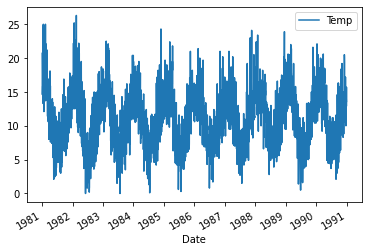

In [2]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('gdrive/My Drive/Colab Notebooks/Forecasting_Datasets/daily-min-temperatures.csv', header=0, index_col="Date", parse_dates=True)
print(series.head())
series.plot()
pyplot.show()

##Quick Check for Autocorrelation

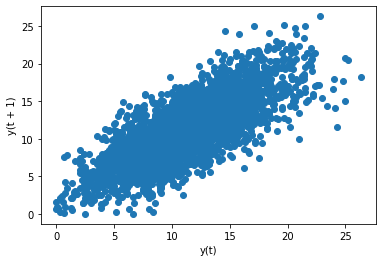

In [3]:
from pandas.plotting import lag_plot
lag_plot(series, lag=1)
pyplot.show()

##Statistical Test (Pearson Correlation COefficient)

Values lies between -1(Negative correlation) and +1(Positive correlation).

Values close to 0 shows no correlation and greater than 0.5 or less than -0.5 belongs to high correlation(+ve or -ve).

In [4]:
from pandas import DataFrame, concat

values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.77487
t+1  0.77487  1.00000


0.77 is a good value to denote the high correlation between the observations.

##AutoCorrelation Plots

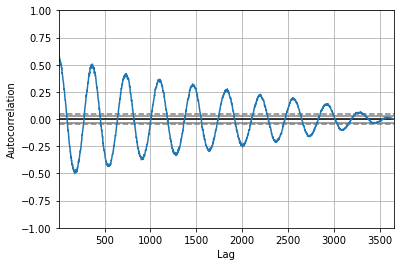

In [5]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
pyplot.show()

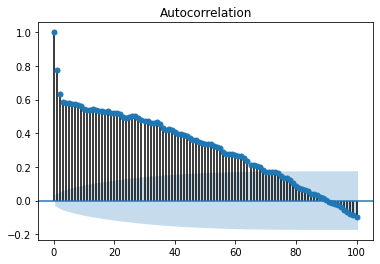

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=100)
pyplot.show()

##Persistence Model

       t-1   t+1
0      NaN  20.7
1     20.7  17.9
2     17.9  18.8
3     18.8  14.6
4     14.6  15.8
...    ...   ...
3645  14.6  14.0
3646  14.0  13.6
3647  13.6  13.5
3648  13.5  15.7
3649  15.7  13.0

[3650 rows x 2 columns]
Test MSE: 3.423


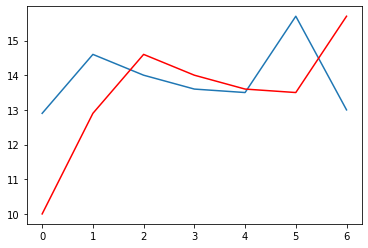

In [7]:
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error

# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe)
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

##AutoRegression Model

In [8]:
# !pip install statsmodels --upgrade

Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


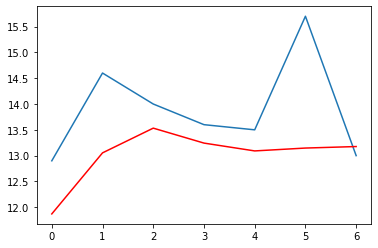

In [14]:
# create and evaluate a static autoregressive model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, old_names=True, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test RMSE: 1.204


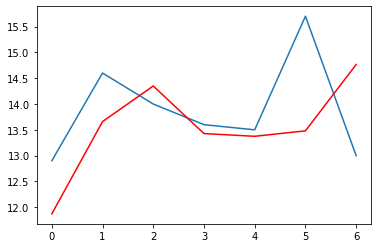

In [16]:
# create and evaluate an updated autoregressive model
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train,old_names=True, lags=29)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()